In [1]:
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import time
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_absolute_error, r2_score
import sklearn

In [2]:
df = pd.read_csv('leg234_data.csv')

In [3]:
df = df.astype(float)
print(df.dtypes)
names = df.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(df)
df = pd.DataFrame(scaled_df, columns=names)

LATITUDE                        float64
LONGITUD                        float64
PDMEAN                          float64
TOTAL                           float64
sf_depth                        float64
PCO2.H2O_mmm                    float64
PCO2.CO2_umm                    float64
NMEA.Humidity                   float64
NMEA.Trykk                      float64
FerryBox.SBE45_Salinity         float64
FerryBox.Optode_Saturation      float64
FerryBox.C3_Turbidity           float64
FerryBox.C3_CHLAFluorescence    float64
FerryBox.C3_Temperature         float64
FerryBox.C3_CDOMFluorescence    float64
day                             float64
month                           float64
time                            float64
dtype: object


In [4]:
def split_data(df):
    y = df.iloc[:, df.columns == 'TOTAL']
    X = df.iloc[:, df.columns != 'TOTAL']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123)

    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
        test_size=0.5, random_state=123) 
    

    return X_train, X_val, y_train, y_val

def smape(A, F):
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [5]:
X_train, X_val, y_train, y_val = split_data(df)

Feature: LATITUDE, Score: 0.12782
Feature: LONGITUD, Score: 0.12170
Feature: PDMEAN, Score: 0.32172
Feature: sf_depth, Score: 0.12302
Feature: PCO2.H2O_mmm, Score: 0.01012
Feature: PCO2.CO2_umm, Score: 0.00875
Feature: NMEA.Humidity, Score: 0.01858
Feature: NMEA.Trykk, Score: 0.04861
Feature: FerryBox.SBE45_Salinity, Score: 0.01652
Feature: FerryBox.Optode_Saturation, Score: 0.03459
Feature: FerryBox.C3_Turbidity, Score: 0.05938
Feature: FerryBox.C3_CHLAFluorescence, Score: 0.00437
Feature: FerryBox.C3_Temperature, Score: 0.02524
Feature: FerryBox.C3_CDOMFluorescence, Score: 0.01055
Feature: day, Score: 0.00888
Feature: month, Score: 0.00252
Feature: time, Score: 0.05763


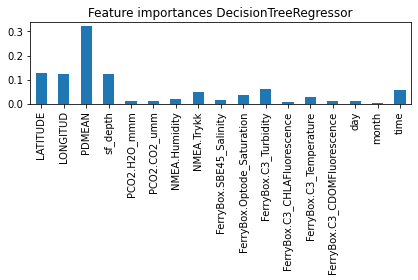

In [6]:
# define the model
model = DecisionTreeRegressor()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print(f'Feature: %s, Score: %.5f' % (X_train.columns[i],v))
# plot feature importance
#pyplot.bar([x for x in range(len(importance))], importance)
importances = pd.Series(importance, index=X_train.columns)

fig, ax = plt.subplots()
importances.plot.bar([x for x in range(len(importance))], importance)
ax.set_title("Feature importances DecisionTreeRegressor")
fig.tight_layout()
plt.show()


In [7]:
y_pred = model.predict(X_val)

In [8]:
print('MAE score: ', mean_absolute_error(y_val, y_pred))
print('R2 score: ', r2_score(y_val, y_pred))
print('Smape score: ', smape(y_val, y_pred.reshape(28458,1)))

MAE score:  0.20307318438499491
R2 score:  0.5308699907638661
Smape score:  TOTAL    0.355545
dtype: float64


In [9]:
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train.values.ravel())
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

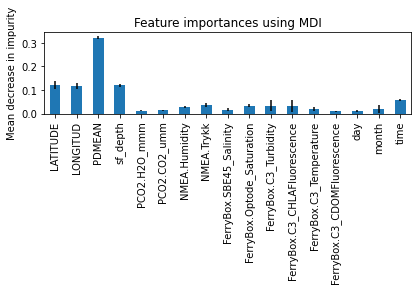

In [10]:
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [11]:
forest_pred = forest.predict(X_val)

In [12]:
print('MAE score: ', mean_absolute_error(y_val, forest_pred))
print('R2 score: ', r2_score(y_val, forest_pred))
print('Smape score: ', smape(y_val, forest_pred.reshape(28458,1)))

MAE score:  0.16384516911687863
R2 score:  0.7163983385752926
Smape score:  TOTAL    0.322244
dtype: float64


In [57]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_val, y_val, n_repeats=10, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=X_train.columns)

Elapsed time to compute the importances: 513.009 seconds


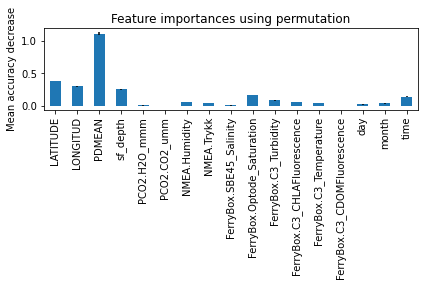

In [58]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Total')

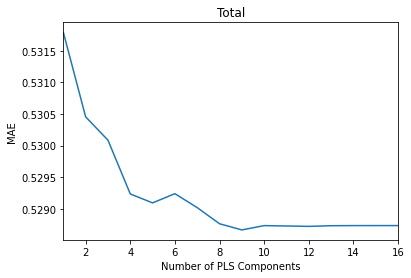

In [13]:
#define cross-validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

mse = []
n = len(X_train)

# Calculate MAPE using cross-validation, adding one component at a time
for i in np.arange(1, 18):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, X_train, y_train, cv=cv,
               scoring='neg_mean_absolute_error').mean()
    mse.append(score)

#plot test MAPE vs. number of components
plt.plot(mse)
plt.xlabel('Number of PLS Components')
plt.ylabel('MAE')
plt.xlim((1,16))
plt.title('Total')

In [14]:
pls = PLSRegression(n_components=9)
pls.fit(X_train, y_train)

PLSRegression(n_components=9)

In [15]:
pls_pred = pls.predict(X_val)

In [16]:
print('MAE score: ', mean_absolute_error(y_val, pls_pred))
print('R2 score: ', r2_score(y_val, pls_pred))
print('Smape score: ', smape(y_val, pls_pred.reshape(28458,1)))

MAE score:  0.530920361283705
R2 score:  0.0682107566853396
Smape score:  TOTAL    1.367921
dtype: float64
